# **SVM & Logistic Regression & PCA**

In [0]:
import os
import csv
import copy 
import math
import random
import time
import operator
from scipy.io import loadmat #for reading .mat files
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from google.colab import drive

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
drive.mount('/content/gdrive',force_remount=True)
root = '/content/gdrive/My Drive/Colab Notebooks/Homework2' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Reading data both q1 and q2 

In [0]:
q1 = os.path.join(root, 'q1_dataset.mat')
q2 = os.path.join(root, 'q2_dataset.mat')

q1_dataset = loadmat(q1)
q2_dataset = loadmat(q2)

 **Extracting the variables as we need them**

In [0]:
inception_features_train = q1_dataset['inception_features_train']
inception_features_test = q1_dataset['inception_features_test']
hog_features_train = q1_dataset['hog_features_train']
hog_features_test = q1_dataset['hog_features_test']
superclass_labels_train = q1_dataset['superclass_labels_train']
superclass_labels_test = q1_dataset['superclass_labels_test']
subclass_labels_train = q1_dataset['subclass_labels_train']
subclass_labels_test = q1_dataset['subclass_labels_test']

# The shape of the variables match with shapes given in homework description 
# All of them are numpy.ndarray

# Question 1 
**Logistic Regression Class**

In [0]:
class LogisticRegression:
  def __init__ (self, learning_rate=0.01,num_iter=1000, batch_size=25):
    self.learning_rate = learning_rate
    self.num_iter = num_iter
    self.batch_size = batch_size
    self.lambd = 0.2

  # function to create a list containing mini-batches 
  def create_mini_batches(self, X, y, batch_size):
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
    for i in range(n_minibatches): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    
    return mini_batches

  # Logistic regression expression 
  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  # for classifying all of the test set
  def test_classify (self, test_classify, treshold, weights): 
    prob = self.sigmoid(np.dot(test_classify, weights))
    prob [prob >= treshold] = int(1)
    prob [prob < treshold ] = int(0)
    return prob.flatten()

  
  def log_likelihood(self, x, y, weights):
    scores = np.dot(x, weights)
    ll = np.sum( np.dot(y.T,scores ) - np.log(1 + np.exp(scores)) )
    return ll

  
  def gradient_ascent (self, x , y):
    # Initializing all weights to random numbers drawn from a Gaussian distribution N(0, 0.01)
    mean, sigma = 0, 0.01 # mean and standard deviation
    weights = np.random.uniform(mean, sigma, size=(x.shape[1],1))
    
    for i in range (self.num_iter):

      # first we need to find the mini batches 
      mini_batches = self.create_mini_batches(x, y, self.batch_size)

      for mini_batch in mini_batches:

        x_mini, y_mini = mini_batch
        h  = self.sigmoid ( np.dot(x_mini, weights) )
        # Updating 
        out = y_mini - h
        gradient = np.dot(x_mini.T, out)
        weights = weights + self.learning_rate * gradient
        
      if i % 100 == 0:         
        log_like = self.log_likelihood(x,y,weights)
        print('Accuracy (Maximum Likelihood Estimation): {} in iteration {} of {}'.format(log_like, i, self.num_iter))

    return weights


  def stochastic_gradient_ascent(self, x ,y):
    # Initializing all weights to random numbers drawn from a Gaussian distribution N(0, 0.01)
    mean, sigma = 0, 0.01 # mean and standard deviation
    weights = np.random.uniform(mean, sigma, size=(x.shape[1],1))
    
    for i in range (self.num_iter):

      # first we need to find the mini batches 
      mini_batches = self.create_mini_batches(x, y, self.batch_size)

      for mini_batch in mini_batches:

        x_mini, y_mini = mini_batch

        h  = self.sigmoid ( np.dot(x_mini, weights) )

        # Updating 
        out = y_mini - h
        gradient = np.dot(x_mini.T, out)
        weights = weights + self.learning_rate * gradient
        
      if i % 100 == 0:         
        log_like = self.log_likelihood(x,y,weights)
        print('Accuracy (Maximum Likelihood Estimation): {} in iteration {} of {}'.format(log_like, i, self.num_iter))

    return weights

  def full_batch_gradient_ascent(self, x ,y):
    # Initializing all weights to random numbers drawn from a Gaussian distribution N(0, 0.01)
    mean, sigma = 0, 0.01 # mean and standard deviation
    weights = np.random.uniform(mean, sigma, size=(x.shape[1],1))

    for i in range (self.num_iter):
      h  = self.sigmoid ( np.dot(x, weights) )

      # Updating 
      out = y - h
      gradient = np.dot(x.T, out)
      weights = weights + self.learning_rate * gradient
        
      if i % 100 == 0:         
        log_like = self.log_likelihood(x,y,weights)
        # If you want to print all weights for each 100 iteration you need to comment out below code
        # print("Weights .. in iteration {} of {} \n {}".format(i, self.num_iter, weights.reshape(324,1)))
        print('Accuracy (Maximum Likelihood Estimation): {} in iteration {} of {}'.format(log_like, i, self.num_iter))

    return weights


  # For finding the results that are asked !! False positive- true positive etc...  
  def report_result(self, predictions, label):
    predictions = predictions.reshape(-1,1)
    label = label
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(predictions)): 
        if label[i]==predictions[i]==1:
           tp += 1
        if predictions[i]==1 and label[i]!=predictions[i]:
           fp += 1
        if label[i]==predictions[i]==0:
           tn += 1
        if predictions[i]==0 and label[i]!=predictions[i]:
           fn += 1

    accuracy = (tp + tn) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    npv = tn / ( tn + fn ) 
    fpr = fp / ( fp + tn )
    fdr = fp / ( fp + tp )
    f1_score = 2 * (recall * precision) / (recall + precision)
    f2_score = (5 * precision * recall) / (4 * precision * recall)
    conf_mat = [[tp , fp],[fn, tn]]
    # print ("Total num : " + str (tp+tn+fn+fp))
    print("Accuracy : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("NPV : {}".format(npv))
    print("FPR : {}".format(fpr))
    print("FDR : {}".format(fdr))
    print("F1 Score : {}".format(f1_score))
    print("F2 Score: {}".format(f2_score))
    print("Confusion Matrix: {}".format(conf_mat))
    return accuracy


# 1.1 Mini-batch gradient ascent algorithm with batch size = 25


In [0]:
learning_rates = [ 1e-6, 1e-5, 1e-3, 1e-1, 1]
best_list = []

for i in learning_rates:
  print("When learning rate is {} .. ".format(i))
  model = LogisticRegression (learning_rate=i,num_iter=1000, batch_size=25) 

  # weights will be found according to learning rate and 
  %time result = model.gradient_ascent ( np.mat(hog_features_train), np.mat(superclass_labels_train) )
  
  # doing predictions according to the weights found
  predictions = model.test_classify(hog_features_test, 0.5 , result)
  
  # finding results 
  accuracy = model.report_result(predictions, superclass_labels_test)
  best_list.append(accuracy)
  print()

max_ind = best_list.index(max(best_list))
best_lr_mini_hog = learning_rates[max_ind]
print("Best learning rate for mini batch trained with hog: {} ".format(best_lr_mini_hog))


When learning rate is 1e-06 .. 
Accuracy (Maximum Likelihood Estimation): 273427.0914863455 in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): 241616.11234644032 in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): 213576.6583103611 in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): 188889.8480584163 in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): 167181.97689637277 in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): 148120.90429081715 in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): 131409.78276675165 in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): 116787.05064088313 in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): 104018.39035671382 in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): 92894.42260649017 in iteration 900 of 1000
CPU times: user 39.3 s, sys: 1.06 s, total: 40.4 s
Wall time: 39.2 s
Accuracy : 0.56
Precision : 0.533519553072625

# Doing everything for the neural network generated features

In [0]:
learning_rates = [ 1e-6, 1e-5, 1e-3, 1e-1, 1]
best_list = []

for i in learning_rates:
  print("When learning rate is {} .. ".format(i))
  model = LogisticRegression (learning_rate=i,num_iter=1000, batch_size=25) 

  # weights will be found according to learning rate and 
  %time result = model.gradient_ascent ( np.mat(inception_features_train), np.mat(superclass_labels_train) )
  
  # doing predictions according to the weights found
  predictions = model.test_classify(inception_features_test, 0.5 , result)

  # finding results 
  accuracy = model.report_result(predictions, superclass_labels_test)
  best_list.append(accuracy)
  print()

max_ind = best_list.index(max(best_list))
best_lr_mini_inc = learning_rates[max_ind]
print("Best learning rate for mini batch trained with neural network: {} ".format(best_lr_mini_inc))

When learning rate is 1e-06 .. 
Accuracy (Maximum Likelihood Estimation): 6367179.533902537 in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): 898307.4802237547 in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): 1423452.8230743473 in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): 1812742.8329761869 in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): 2114842.7224720744 in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): 2360886.824007906 in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): 2568668.84492831 in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): 2744887.0127428803 in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): 2899412.4204894677 in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): 3034781.4175105295 in iteration 900 of 1000
CPU times: user 3min 14s, sys: 2min 14s, total: 5min 29s
Wall time: 2min 51s
Accuracy : 0.8775
Precision : 0.854460

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Accuracy (Maximum Likelihood Estimation): -inf in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 900 of 1000
CPU times: user 3min 34s, sys: 2min 20s, total: 5min 55s
Wall time: 3min 8s
Accuracy : 0.875
Precision : 0.8676470588235294
Recall : 0.885
NPV : 0.8826530612244898
FPR : 0.135
FDR : 0.1323529411764706
F1 Score : 0.8762376237623763
F2 Score: 1.2499999999999998
Confusion Matrix: [[17

# 1.1 Stochastic gradient ascent

In [0]:
learning_rates = [ 1e-6, 1e-5, 1e-3, 1e-1, 1]
best_list = []

for i in learning_rates:
  print("When learning rate is {} .. ".format(i))
  model = LogisticRegression (learning_rate=i,num_iter=1000, batch_size=25) 

  # weights will be found according to learning rate and 
  %time result = model.stochastic_gradient_ascent ( np.mat(hog_features_train), np.mat(superclass_labels_train) )
  
  # doing predictions according to the weights found
  predictions = model.test_classify(hog_features_test, 0.5 , result)
  
  # finding results 
  accuracy = model.report_result(predictions, superclass_labels_test)
  best_list.append(accuracy)
  print()

max_ind = best_list.index(max(best_list))
best_lr_sch_hog = learning_rates[max_ind]
print("Best learning rate for stochastic trained with hog: {} ".format(best_lr_sch_hog))


When learning rate is 1e-06 .. 
Accuracy (Maximum Likelihood Estimation): 260955.64194283803 in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): 230487.89854520606 in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): 203643.47246131324 in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): 180018.69335232163 in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): 159255.27377584117 in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): 141033.7174820312 in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): 125068.4799164208 in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): 111108.13837444544 in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): 98927.76799749944 in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): 88326.84882387624 in iteration 900 of 1000
CPU times: user 39.3 s, sys: 1.09 s, total: 40.4 s
Wall time: 39.2 s
Accuracy : 0.575
Precision : 0.54310344827586

# Doing everything for the neural network generated features

In [0]:
learning_rates = [ 1e-6, 1e-5, 1e-3, 1e-1, 1]
best_list = []

for i in learning_rates:
  print("When learning rate is {} .. ".format(i))
  model = LogisticRegression (learning_rate=i,num_iter=1000, batch_size=25) 

  # weights will be found according to learning rate and 
  %time result = model.stochastic_gradient_ascent ( np.mat(inception_features_train), np.mat(superclass_labels_train) )
  
  # doing predictions according to the weights found
  predictions = model.test_classify(inception_features_test, 0.5 , result)
  
  # finding results 
  accuracy = model.report_result(predictions, superclass_labels_test)
  best_list.append(accuracy)
  print()

max_ind = best_list.index(max(best_list))
best_lr_sch_inc = learning_rates[max_ind]
print("Best learning rate for stochastic trained with neural net: {} ".format(best_lr_sch_inc))


When learning rate is 1e-06 .. 
Accuracy (Maximum Likelihood Estimation): 6329493.528840523 in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): 882828.2349132972 in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): 1412973.7971323684 in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): 1801347.8731096047 in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): 2105242.5966874426 in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): 2353694.259035919 in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): 2560792.3328034785 in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): 2737025.16713111 in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): 2893170.3810170805 in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): 3029538.239085174 in iteration 900 of 1000
CPU times: user 3min 17s, sys: 2min 15s, total: 5min 32s
Wall time: 2min 51s
Accuracy : 0.875
Precision : 0.84722222

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Accuracy (Maximum Likelihood Estimation): -inf in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 900 of 1000
CPU times: user 4min 11s, sys: 2min 27s, total: 6min 38s
Wall time: 3min 43s
Accuracy : 0.8725
Precision : 0.8860103626943006
Recall : 0.855
NPV : 0.8599033816425121
FPR : 0.11
FDR : 0.11398963730569948
F1 Score : 0.8702290076335878
F2 Score: 1.25
Confusion Matrix: [[171, 22], [29,

# 1.2 Full batch gradient ascent

In [0]:
import operator
# learning_rates = [ best_lr_mini_hog, best_lr_sch_hog]
learning_rates = [ 1e-5]
best_list = []

for i in learning_rates:
  print("When learning rate is {} .. ".format(i))
  model = LogisticRegression (learning_rate=i,num_iter=1000, batch_size=25) 

  # weights will be found according to learning rate and 
  %time result = model.full_batch_gradient_ascent( np.mat(hog_features_train), np.mat(superclass_labels_train) )
  
  indexed = list(enumerate(result))
  top_10 = sorted(indexed, key=operator.itemgetter(1))[-10:]
  indexs = list(reversed([i for i, v in top_10]))
  print ("10 most important feature indices: \n{}".format(indexs))

  # doing predictions according to the weights found
  predictions = model.test_classify(hog_features_test, 0.5 , result)
  
  # finding results 
  accuracy = model.report_result(predictions, superclass_labels_test)
  

When learning rate is 1e-05 .. 
Accuracy (Maximum Likelihood Estimation): 265243.39106075594 in iteration 0 of 1000
Accuracy (Maximum Likelihood Estimation): 80816.41241650014 in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): 38238.91713944322 in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): 38208.806926963436 in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): 50670.861107721284 in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): 66553.62273514502 in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): 83128.30914121075 in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): 99583.04873964612 in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): 115685.16690460345 in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): 131376.7084477212 in iteration 900 of 1000
CPU times: user 886 ms, sys: 183 ms, total: 1.07 s
Wall time: 555 ms
10 most important feature indices: 
[164, 289, 

# Doing everything for the neural network generated features

In [0]:
# learning_rates = [ best_lr_mini_inc, best_lr_sch_inc]
learning_rates = [ 0.1 ]
best_list = []

for i in learning_rates:
  print("When learning rate is {} .. ".format(i))
  model = LogisticRegression (learning_rate=i,num_iter=1000, batch_size=25) 

  # weights will be found according to learning rate and 
  %time result = model.full_batch_gradient_ascent( np.mat(inception_features_train), np.mat(superclass_labels_train) )
  
  indexed = list(enumerate(result))
  top_10 = sorted(indexed, key=operator.itemgetter(1))[-10:]
  indexs = list(reversed([i for i, v in top_10]))
  print ("10 most important feature indices: \n{}".format(indexs))

  # doing predictions according to the weights found
  predictions = model.test_classify(inception_features_test, 0.5 , result)
  
  # finding results 
  accuracy = model.report_result(predictions, superclass_labels_test)
  


When learning rate is 0.1 .. 
Accuracy (Maximum Likelihood Estimation): -57436699248.75962 in iteration 0 of 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Accuracy (Maximum Likelihood Estimation): -inf in iteration 100 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 200 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 300 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 400 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 500 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 600 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 700 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 800 of 1000
Accuracy (Maximum Likelihood Estimation): -inf in iteration 900 of 1000
CPU times: user 6.18 s, sys: 326 ms, total: 6.5 s
Wall time: 3.35 s
10 most important feature indices: 
[123, 993, 1948, 1783, 1189, 1108, 1928, 187, 1020, 287]
Accuracy : 0.8875
Precision : 0.8934010152284264
Recall : 0.88
NPV : 0.8817733990147784
FPR : 0.105
FDR : 0.1065989847715736
F1 Score : 0.8866498740554157
F2 Score: 1.25
Confusion Matrix: [[1

# Question 1.3
**Superclass Classication Using SVM**


In [0]:
inception_features_train = q1_dataset['inception_features_train']
inception_features_test = q1_dataset['inception_features_test']
hog_features_train = q1_dataset['hog_features_train']
hog_features_test = q1_dataset['hog_features_test']
superclass_labels_train = q1_dataset['superclass_labels_train']
superclass_labels_test = q1_dataset['superclass_labels_test']

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from statistics import mean 

class class_svm:
  #def __init__ (self):
  
  def stratified_k_fold(self, features, labels, k):
    result = []
    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(features, labels):
      # print("TRAIN:", len(train_index), "TEST:", len(test_index))
      X_train, X_test = features[train_index], features[test_index]
      y_train, y_test = labels[train_index], labels[test_index]
      result.append ( [ X_train , X_test , y_train , y_test ] )

    return np.asarray(result)

  def train_soft_margin_svm (self, fold, cs):
    
    X_train,X_test,y_train,y_test = fold
    y_train = y_train.flatten()
    
    all_acc = []
    all_pred = []
    all_recall = []
    all_f1 = []

    #Create a svm Classifier
    for c in cs: 
      
      # Linear Kernel
      clf = svm.SVC(kernel='linear',C=c) 
      #Train the model using the training sets
      clf.fit(X_train, y_train)
      #Predict the response for test dataset
      y_pred = clf.predict(X_test)

      # Model Accuracy: how often is the classifier correct?
      acc =  metrics.accuracy_score(y_test, y_pred)
      all_acc.append(acc)
      # Model Precision: what percentage of positive tuples are labeled as such?
      pred = metrics.precision_score(y_test, y_pred)
      all_pred.append(pred)
      # Model Recall: what percentage of positive tuples are labelled as such?
      recall = metrics.recall_score(y_test, y_pred)
      all_recall.append( recall)
      # Model F1 Score:
      f1 = metrics.f1_score(y_test, y_pred)
      all_f1.append(f1)

      print("When c= {}, Accuracy: {}".format(c,acc)) 
      print("When c= {}, Precision: {}".format(c, pred))
      print("When c= {}, Recall: {}".format(c, recall))
      print("When c= {}, F1 Score: {}".format(c, f1))

    if len(cs) != 1:
      return all_acc

    else:    
      cnf_matrix = confusion_matrix(y_test, y_pred)
      print(cnf_matrix)

    print()


  def train_hard_margin_svm (self, fold, gamas):
    X_train,X_test,y_train,y_test = fold
    y_train = y_train.flatten()
    
    all_acc = []
    all_pred = []
    all_recall = []
    all_f1 = []

    #Create a svm Classifier
    for gama in gamas: 
      
      # RBF Kernel
      clf = svm.SVC(kernel='rbf', gamma=gama, C= 1e11) 
      #Train the model using the training sets
      clf.fit(X_train, y_train)
      #Predict the response for test dataset
      y_pred = clf.predict(X_test)

      # Model Accuracy: how often is the classifier correct?
      acc =  metrics.accuracy_score(y_test, y_pred)
      all_acc.append(acc)
      # Model Precision: what percentage of positive tuples are labeled as such?
      pred = metrics.precision_score(y_test, y_pred)
      all_pred.append(pred)
      # Model Recall: what percentage of positive tuples are labelled as such?
      recall = metrics.recall_score(y_test, y_pred)
      all_recall.append(recall)
      # Model F1 Score:
      f1 = metrics.f1_score(y_test, y_pred)
      all_f1.append(f1)
      
      print("When gamma= {}, Accuracy: {}".format(gama,acc)) 
      print("When gamma= {}, Precision: {}".format(gama, pred))
      print("When gamma= {}, Recall: {}".format(gama, recall))
      print("When gamma= {}, F1 Score: {}".format(gama, f1))

    if len(gamas) != 1:
      return all_acc

    else:
      cnf_matrix = confusion_matrix(y_test, y_pred)
      print(cnf_matrix)
    print()

  def train_soft_margin_svm_last (self, fold, gamas, cs):
    
    # Test and training data,label
    X_train,X_test,y_train,y_test = fold
    y_train = y_train.flatten()

    all_acc = []
    all_pred = []
    all_recall = []
    all_f1 = []

    for c in cs:

      for gama in gamas:

        # RBF Kernel
        clf = svm.SVC(kernel='rbf', gamma=gama, C=c) 
        #Train the model using the training sets
        clf.fit(X_train, y_train)
        #Predict the response for test dataset
        y_pred = clf.predict(X_test)

        # Model Accuracy: how often is the classifier correct?
        acc =  metrics.accuracy_score(y_test, y_pred)
        all_acc.append(acc)
        # Model Precision: what percentage of positive tuples are labeled as such?
        pred = metrics.precision_score(y_test, y_pred)
        all_pred.append(pred)
        # Model Recall: what percentage of positive tuples are labelled as such?
        recall = metrics.recall_score(y_test, y_pred)
        all_recall.append(recall)
        # Model F1 Score:
        f1 = metrics.f1_score(y_test, y_pred)
        all_f1.append(f1)
        
        print("When gamma= {}, c = {}, Accuracy: {}".format(gama, c,acc)) 
        print("When gamma= {}, c = {}, Precision: {}".format(gama, c, pred))
        print("When gamma= {}, c = {}, Recall: {}".format(gama, c, recall))
        print("When gamma= {}, c = {}, F1 Score: {}".format(gama, c, f1))
        print()

    if len(gamas) != 1:
      return all_acc

    else:
      cnf_matrix = confusion_matrix(y_test, y_pred)
      print(cnf_matrix)

    print()

# 1.4 Train a soft margin SVM model with linear kernel. 
Tune C hyper-parameter of the model using 5-fold cross validation on the training dataset.

In [0]:
cs  = [1e-2, 1e-1, 1, 1e1, 1e2]
model = class_svm()
result = model.stratified_k_fold(features= hog_features_train, labels = superclass_labels_train, k=5)
f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time f1 = model.train_soft_margin_svm(result[i], cs)
  f1s.append(f1)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
best = ind_arr[0][0]
print("Best of the C value: {} \n".format(cs[best]))
print(avg_f1)
  

Fold 1 is processing...
When c= 0.01, Accuracy: 0.7025
When c= 0.01, Precision: 0.7120418848167539
When c= 0.01, Recall: 0.68
When c= 0.01, F1 Score: 0.6956521739130435
When c= 0.1, Accuracy: 0.705
When c= 0.1, Precision: 0.6952380952380952
When c= 0.1, Recall: 0.73
When c= 0.1, F1 Score: 0.7121951219512195
When c= 1, Accuracy: 0.6975
When c= 1, Precision: 0.6854460093896714
When c= 1, Recall: 0.73
When c= 1, F1 Score: 0.7070217917675543
When c= 10.0, Accuracy: 0.6625
When c= 10.0, Precision: 0.6511627906976745
When c= 10.0, Recall: 0.7
When c= 10.0, F1 Score: 0.674698795180723
When c= 100.0, Accuracy: 0.6475
When c= 100.0, Precision: 0.645320197044335
When c= 100.0, Recall: 0.655
When c= 100.0, F1 Score: 0.6501240694789082
CPU times: user 7.77 s, sys: 6.99 ms, total: 7.78 s
Wall time: 7.78 s

Fold 2 is processing...
When c= 0.01, Accuracy: 0.66
When c= 0.01, Precision: 0.7077922077922078
When c= 0.01, Recall: 0.545
When c= 0.01, F1 Score: 0.615819209039548
When c= 0.1, Accuracy: 0.682

**After selecting optimal C value**

In [0]:
c  = [ cs[best] ]
model = class_svm()
fold = [hog_features_train, hog_features_test, superclass_labels_train, superclass_labels_test]
%time model.train_soft_margin_svm(fold, c)

When c= 0.1, Accuracy: 0.68
When c= 0.1, Precision: 0.7
When c= 0.1, Recall: 0.63
When c= 0.1, F1 Score: 0.663157894736842
[[146  54]
 [ 74 126]]

CPU times: user 1.79 s, sys: 10 ms, total: 1.8 s
Wall time: 1.8 s


# Doing everything for the neural network generated features

In [0]:
cs  = [1e-2, 1e-1, 1, 1e1, 1e2]
model = class_svm()
result = model.stratified_k_fold(features= inception_features_train, labels = superclass_labels_train, k=5)
f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time f1 = model.train_soft_margin_svm(result[i], cs)
  f1s.append(f1)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
best = ind_arr[0][0]
print("Best of the C value: {} \n".format(cs[best]))
print(avg_f1)

Fold 1 is processing...
When c= 0.01, Accuracy: 0.895
When c= 0.01, Precision: 0.8798076923076923
When c= 0.01, Recall: 0.915
When c= 0.01, F1 Score: 0.8970588235294118
When c= 0.1, Accuracy: 0.86
When c= 0.1, Precision: 0.8495145631067961
When c= 0.1, Recall: 0.875
When c= 0.1, F1 Score: 0.8620689655172414
When c= 1, Accuracy: 0.8625
When c= 1, Precision: 0.8571428571428571
When c= 1, Recall: 0.87
When c= 1, F1 Score: 0.8635235732009925
When c= 10.0, Accuracy: 0.8625
When c= 10.0, Precision: 0.8571428571428571
When c= 10.0, Recall: 0.87
When c= 10.0, F1 Score: 0.8635235732009925
When c= 100.0, Accuracy: 0.8625
When c= 100.0, Precision: 0.8571428571428571
When c= 100.0, Recall: 0.87
When c= 100.0, F1 Score: 0.8635235732009925
CPU times: user 18.7 s, sys: 19 ms, total: 18.7 s
Wall time: 18.7 s

Fold 2 is processing...
When c= 0.01, Accuracy: 0.8875
When c= 0.01, Precision: 0.8855721393034826
When c= 0.01, Recall: 0.89
When c= 0.01, F1 Score: 0.887780548628429
When c= 0.1, Accuracy: 0.89

**After selecting optimal C value**

In [0]:
c  = [ cs[best] ] 
model = class_svm()
fold = [inception_features_train, inception_features_test, superclass_labels_train, superclass_labels_test]
%time model.train_soft_margin_svm(fold, c)

When c= 0.01, Accuracy: 0.8925
When c= 0.01, Precision: 0.8792270531400966
When c= 0.01, Recall: 0.91
When c= 0.01, F1 Score: 0.8943488943488944
[[175  25]
 [ 18 182]]

CPU times: user 5.84 s, sys: 15 ms, total: 5.85 s
Wall time: 5.85 s


# 1.5 Train a hard margin SVM with radial basis function (rbf) kernel.

In [7]:
gamas  = [2**-4, 2**-3, 2**-2, 2**-1 , 2**0, 2**1, 2**6]
print(gamas)
model = class_svm()
result = model.stratified_k_fold(features= hog_features_train, labels = superclass_labels_train, k=5)
f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time f1 = model.train_hard_margin_svm(result[i], gamas)
  f1s.append(f1)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
best = ind_arr[0][0]
print("Best of the Gamma value: {} \n".format(gamas[best]))
print(avg_f1)

[0.0625, 0.125, 0.25, 0.5, 1, 2, 64]
Fold 1 is processing...
When gamma= 0.0625, Accuracy: 0.6525
When gamma= 0.0625, Precision: 0.6564102564102564
When gamma= 0.0625, Recall: 0.64
When gamma= 0.0625, F1 Score: 0.6481012658227848
When gamma= 0.125, Accuracy: 0.6425
When gamma= 0.125, Precision: 0.6476683937823834
When gamma= 0.125, Recall: 0.625
When gamma= 0.125, F1 Score: 0.6361323155216284
When gamma= 0.25, Accuracy: 0.6625
When gamma= 0.25, Precision: 0.6666666666666666
When gamma= 0.25, Recall: 0.65
When gamma= 0.25, F1 Score: 0.6582278481012659
When gamma= 0.5, Accuracy: 0.6975
When gamma= 0.5, Precision: 0.7046632124352331
When gamma= 0.5, Recall: 0.68
When gamma= 0.5, F1 Score: 0.6921119592875319
When gamma= 1, Accuracy: 0.72
When gamma= 1, Precision: 0.7315789473684211
When gamma= 1, Recall: 0.695
When gamma= 1, F1 Score: 0.7128205128205127
When gamma= 2, Accuracy: 0.715
When gamma= 2, Precision: 0.7107843137254902
When gamma= 2, Recall: 0.725
When gamma= 2, F1 Score: 0.717821

**After selecting optimal Gamma value**

In [8]:
gama  = [ gamas[best] ]
model = class_svm()
fold = [hog_features_train, hog_features_test, superclass_labels_train, superclass_labels_test]
%time model.train_hard_margin_svm(fold, gama)

When gamma= 1, Accuracy: 0.7225
When gamma= 1, Precision: 0.7192118226600985
When gamma= 1, Recall: 0.73
When gamma= 1, F1 Score: 0.7245657568238213
[[143  57]
 [ 54 146]]

CPU times: user 2.51 s, sys: 27 ms, total: 2.54 s
Wall time: 2.54 s


# Doing everything for the neural network generated features

In [9]:
gamas  = [2**-4, 2**-3, 2**-2, 2**-1 , 2**0, 2**1, 2**6]
print(gamas)
model = class_svm()
result = model.stratified_k_fold(features= inception_features_train, labels = superclass_labels_train, k=5)
f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time f1 = model.train_hard_margin_svm(result[i], gamas)
  f1s.append(f1)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
best = ind_arr[0][0]
print("Best of the Gamma value: {} \n".format(gamas[best]))
print(avg_f1)


[0.0625, 0.125, 0.25, 0.5, 1, 2, 64]
Fold 1 is processing...
When gamma= 0.0625, Accuracy: 0.615
When gamma= 0.0625, Precision: 0.5657142857142857
When gamma= 0.0625, Recall: 0.99
When gamma= 0.0625, F1 Score: 0.72
When gamma= 0.125, Accuracy: 0.5175
When gamma= 0.125, Precision: 0.8888888888888888
When gamma= 0.125, Recall: 0.04
When gamma= 0.125, F1 Score: 0.07655502392344497
When gamma= 0.25, Accuracy: 0.5
When gamma= 0.25, Precision: 0.5
When gamma= 0.25, Recall: 0.005
When gamma= 0.25, F1 Score: 0.009900990099009901


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 0.5, Accuracy: 0.5
When gamma= 0.5, Precision: 0.0
When gamma= 0.5, Recall: 0.0
When gamma= 0.5, F1 Score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 1, Accuracy: 0.5
When gamma= 1, Precision: 0.0
When gamma= 1, Recall: 0.0
When gamma= 1, F1 Score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, Accuracy: 0.5
When gamma= 2, Precision: 0.0
When gamma= 2, Recall: 0.0
When gamma= 2, F1 Score: 0.0
When gamma= 64, Accuracy: 0.5
When gamma= 64, Precision: 0.5
When gamma= 64, Recall: 1.0
When gamma= 64, F1 Score: 0.6666666666666666
CPU times: user 1min 16s, sys: 40.1 ms, total: 1min 16s
Wall time: 1min 16s

Fold 2 is processing...
When gamma= 0.0625, Accuracy: 0.55
When gamma= 0.0625, Precision: 0.526595744680851
When gamma= 0.0625, Recall: 0.99
When gamma= 0.0625, F1 Score: 0.6875000000000001
When gamma= 0.125, Accuracy: 0.52
When gamma= 0.125, Precision: 0.5102040816326531
When gamma= 0.125, Recall: 1.0
When gamma= 0.125, F1 Score: 0.6756756756756758
When gamma= 0.25, Accuracy: 0.5075
When gamma= 0.25, Precision: 0.5037783375314862
When gamma= 0.25, Recall: 1.0
When gamma= 0.25, F1 Score: 0.6700167504187605
When gamma= 0.5, Accuracy: 0.5025
When gamma= 0.5, Precision: 0.5012531328320802
When gamma= 0.5, Recall: 1.0
When gamma= 0.5, F1 Score: 0.667779632721202
When ga

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 0.5, Accuracy: 0.5
When gamma= 0.5, Precision: 0.0
When gamma= 0.5, Recall: 0.0
When gamma= 0.5, F1 Score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 1, Accuracy: 0.5
When gamma= 1, Precision: 0.0
When gamma= 1, Recall: 0.0
When gamma= 1, F1 Score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, Accuracy: 0.5
When gamma= 2, Precision: 0.0
When gamma= 2, Recall: 0.0
When gamma= 2, F1 Score: 0.0
When gamma= 64, Accuracy: 0.5
When gamma= 64, Precision: 0.5
When gamma= 64, Recall: 1.0
When gamma= 64, F1 Score: 0.6666666666666666
CPU times: user 1min 16s, sys: 16.9 ms, total: 1min 16s
Wall time: 1min 16s

Fold 4 is processing...
When gamma= 0.0625, Accuracy: 0.6075
When gamma= 0.0625, Precision: 0.5605633802816902
When gamma= 0.0625, Recall: 0.995
When gamma= 0.0625, F1 Score: 0.7171171171171171
When gamma= 0.125, Accuracy: 0.5175
When gamma= 0.125, Precision: 0.5089514066496164
When gamma= 0.125, Recall: 0.995
When gamma= 0.125, F1 Score: 0.6734348561759729
When gamma= 0.25, Accuracy: 0.5025
When gamma= 0.25, Precision: 0.5012531328320802
When gamma= 0.25, Recall: 1.0
When gamma= 0.25, F1 Score: 0.667779632721202
When gamma= 0.5, Accuracy: 0.5025
When gamma= 0.5, Precision: 0.5012531328320802
When gamma= 0.5, Recall: 1.0
When gamma= 0.5, F1 Score: 0.667779632721202


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 1, Accuracy: 0.5
When gamma= 1, Precision: 0.0
When gamma= 1, Recall: 0.0
When gamma= 1, F1 Score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, Accuracy: 0.5
When gamma= 2, Precision: 0.0
When gamma= 2, Recall: 0.0
When gamma= 2, F1 Score: 0.0
When gamma= 64, Accuracy: 0.5
When gamma= 64, Precision: 0.5
When gamma= 64, Recall: 1.0
When gamma= 64, F1 Score: 0.6666666666666666
CPU times: user 1min 16s, sys: 19.9 ms, total: 1min 16s
Wall time: 1min 16s

Best of the Gamma value: 0.0625 

[0.592  0.522  0.5035 0.5015 0.501  0.501  0.5   ]


In [10]:
gama  = [ gamas[best] ]
model = class_svm()
fold = [inception_features_train, inception_features_test, superclass_labels_train, superclass_labels_test]
%time model.train_hard_margin_svm(fold, gama)

When gamma= 0.0625, Accuracy: 0.5875
When gamma= 0.0625, Precision: 0.547945205479452
When gamma= 0.0625, Recall: 1.0
When gamma= 0.0625, F1 Score: 0.7079646017699115
[[ 35 165]
 [  0 200]]

CPU times: user 16.4 s, sys: 23 ms, total: 16.5 s
Wall time: 16.5 s


# 1.6 Train a soft margin SVM with radial basis function (rbf) as kernel.

In [0]:
gamas = [2**-2, 2**1, 2**6]
cs  = [1e-2, 1, 1e2]
model = class_svm()
result = model.stratified_k_fold(features= hog_features_train, labels = superclass_labels_train, k=5)
f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time best = model.train_soft_margin_svm_last(result[i], gamas , cs)
  f1s.append(best)

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
ind = ind_arr[0][0]
print("Best of the Gamma value: {}, C value: {} \n".format(gamas[ind%3], cs [int(ind/3)]))
print(avg_f1)

Fold 1 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.6725
When gamma= 0.25, c = 0.01, Precision: 0.6844919786096256
When gamma= 0.25, c = 0.01, Recall: 0.64
When gamma= 0.25, c = 0.01, F1 Score: 0.661498708010336

When gamma= 2, c = 0.01, Accuracy: 0.6875
When gamma= 2, c = 0.01, Precision: 0.6794258373205742
When gamma= 2, c = 0.01, Recall: 0.71
When gamma= 2, c = 0.01, F1 Score: 0.6943765281173594

When gamma= 64, c = 0.01, Accuracy: 0.5
When gamma= 64, c = 0.01, Precision: 0.5
When gamma= 64, c = 0.01, Recall: 1.0
When gamma= 64, c = 0.01, F1 Score: 0.6666666666666666

When gamma= 0.25, c = 1, Accuracy: 0.7075
When gamma= 0.25, c = 1, Precision: 0.7150259067357513
When gamma= 0.25, c = 1, Recall: 0.69
When gamma= 0.25, c = 1, F1 Score: 0.7022900763358778

When gamma= 2, c = 1, Accuracy: 0.71
When gamma= 2, c = 1, Precision: 0.6981132075471698
When gamma= 2, c = 1, Recall: 0.74
When gamma= 2, c = 1, F1 Score: 0.7184466019417476

When gamma= 64, c = 1, Accuracy: 0.5
When ga

In [0]:
gama = [gamas[ind%3]]
c = [cs [int(ind/3)]]
fold = [hog_features_train, hog_features_test, superclass_labels_train, superclass_labels_test]
model = class_svm()
%time best = model.train_soft_margin_svm_last(fold, gama , c)

When gamma= 2, c = 100.0, Accuracy: 0.7075
When gamma= 2, c = 100.0, Precision: 0.6966824644549763
When gamma= 2, c = 100.0, Recall: 0.735
When gamma= 2, c = 100.0, F1 Score: 0.7153284671532847

[[136  64]
 [ 53 147]]

CPU times: user 2.54 s, sys: 1e+03 µs, total: 2.54 s
Wall time: 2.55 s


# Doing everything for the neural network generated features


In [0]:
gamas = [2**-2, 2**1, 2**6]
cs  = [1e-2, 1, 1e2]
model = class_svm()
result = model.stratified_k_fold(features= inception_features_train, labels = superclass_labels_train, k=5)
f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time best = model.train_soft_margin_svm_last(result[i], gamas , cs)
  f1s.append(best)

avg_f1 = np.average(f1s, axis=0)
print(avg_f1)
ind_arr = np.where(avg_f1 == max(avg_f1))
ind = ind_arr[0][0]
print("Best of the Gamma value: {}, C value: {} \n".format(gamas[ind%3], cs [int(ind/3)]))
print(avg_f1)

Fold 1 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.5025
When gamma= 0.25, c = 0.01, Precision: 1.0
When gamma= 0.25, c = 0.01, Recall: 0.005
When gamma= 0.25, c = 0.01, F1 Score: 0.009950248756218907

When gamma= 2, c = 0.01, Accuracy: 0.8375
When gamma= 2, c = 0.01, Precision: 0.8609625668449198
When gamma= 2, c = 0.01, Recall: 0.805
When gamma= 2, c = 0.01, F1 Score: 0.8320413436692506

When gamma= 64, c = 0.01, Accuracy: 0.5
When gamma= 64, c = 0.01, Precision: 0.5
When gamma= 64, c = 0.01, Recall: 1.0
When gamma= 64, c = 0.01, F1 Score: 0.6666666666666666

When gamma= 0.25, c = 1, Accuracy: 0.51
When gamma= 0.25, c = 1, Precision: 0.5050505050505051
When gamma= 0.25, c = 1, Recall: 1.0
When gamma= 0.25, c = 1, F1 Score: 0.6711409395973155



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, c = 1, Accuracy: 0.5
When gamma= 2, c = 1, Precision: 0.0
When gamma= 2, c = 1, Recall: 0.0
When gamma= 2, c = 1, F1 Score: 0.0

When gamma= 64, c = 1, Accuracy: 0.5
When gamma= 64, c = 1, Precision: 0.5
When gamma= 64, c = 1, Recall: 1.0
When gamma= 64, c = 1, F1 Score: 0.6666666666666666

When gamma= 0.25, c = 100.0, Accuracy: 0.515
When gamma= 0.25, c = 100.0, Precision: 0.5076142131979695
When gamma= 0.25, c = 100.0, Recall: 1.0
When gamma= 0.25, c = 100.0, F1 Score: 0.6734006734006733



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, c = 100.0, Accuracy: 0.5
When gamma= 2, c = 100.0, Precision: 0.0
When gamma= 2, c = 100.0, Recall: 0.0
When gamma= 2, c = 100.0, F1 Score: 0.0

When gamma= 64, c = 100.0, Accuracy: 0.5
When gamma= 64, c = 100.0, Precision: 0.5
When gamma= 64, c = 100.0, Recall: 1.0
When gamma= 64, c = 100.0, F1 Score: 0.6666666666666666

CPU times: user 1min 36s, sys: 35 ms, total: 1min 36s
Wall time: 1min 36s
Fold 2 is processing...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 0.25, c = 0.01, Accuracy: 0.5
When gamma= 0.25, c = 0.01, Precision: 0.0
When gamma= 0.25, c = 0.01, Recall: 0.0
When gamma= 0.25, c = 0.01, F1 Score: 0.0

When gamma= 2, c = 0.01, Accuracy: 0.8425
When gamma= 2, c = 0.01, Precision: 0.8442211055276382
When gamma= 2, c = 0.01, Recall: 0.84
When gamma= 2, c = 0.01, F1 Score: 0.8421052631578947

When gamma= 64, c = 0.01, Accuracy: 0.5
When gamma= 64, c = 0.01, Precision: 0.5
When gamma= 64, c = 0.01, Recall: 1.0
When gamma= 64, c = 0.01, F1 Score: 0.6666666666666666

When gamma= 0.25, c = 1, Accuracy: 0.5025
When gamma= 0.25, c = 1, Precision: 0.5012531328320802
When gamma= 0.25, c = 1, Recall: 1.0
When gamma= 0.25, c = 1, F1 Score: 0.667779632721202



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, c = 1, Accuracy: 0.5
When gamma= 2, c = 1, Precision: 0.0
When gamma= 2, c = 1, Recall: 0.0
When gamma= 2, c = 1, F1 Score: 0.0

When gamma= 64, c = 1, Accuracy: 0.5
When gamma= 64, c = 1, Precision: 0.5
When gamma= 64, c = 1, Recall: 1.0
When gamma= 64, c = 1, F1 Score: 0.6666666666666666

When gamma= 0.25, c = 100.0, Accuracy: 0.5025
When gamma= 0.25, c = 100.0, Precision: 0.5012531328320802
When gamma= 0.25, c = 100.0, Recall: 1.0
When gamma= 0.25, c = 100.0, F1 Score: 0.667779632721202



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, c = 100.0, Accuracy: 0.5
When gamma= 2, c = 100.0, Precision: 0.0
When gamma= 2, c = 100.0, Recall: 0.0
When gamma= 2, c = 100.0, F1 Score: 0.0

When gamma= 64, c = 100.0, Accuracy: 0.5
When gamma= 64, c = 100.0, Precision: 0.5
When gamma= 64, c = 100.0, Recall: 1.0
When gamma= 64, c = 100.0, F1 Score: 0.6666666666666666

CPU times: user 1min 34s, sys: 17 ms, total: 1min 34s
Wall time: 1min 35s
Fold 3 is processing...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 0.25, c = 0.01, Accuracy: 0.5
When gamma= 0.25, c = 0.01, Precision: 0.0
When gamma= 0.25, c = 0.01, Recall: 0.0
When gamma= 0.25, c = 0.01, F1 Score: 0.0

When gamma= 2, c = 0.01, Accuracy: 0.8075
When gamma= 2, c = 0.01, Precision: 0.8397790055248618
When gamma= 2, c = 0.01, Recall: 0.76
When gamma= 2, c = 0.01, F1 Score: 0.7979002624671917

When gamma= 64, c = 0.01, Accuracy: 0.5
When gamma= 64, c = 0.01, Precision: 0.5
When gamma= 64, c = 0.01, Recall: 1.0
When gamma= 64, c = 0.01, F1 Score: 0.6666666666666666



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 0.25, c = 1, Accuracy: 0.5
When gamma= 0.25, c = 1, Precision: 0.0
When gamma= 0.25, c = 1, Recall: 0.0
When gamma= 0.25, c = 1, F1 Score: 0.0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, c = 1, Accuracy: 0.5
When gamma= 2, c = 1, Precision: 0.0
When gamma= 2, c = 1, Recall: 0.0
When gamma= 2, c = 1, F1 Score: 0.0

When gamma= 64, c = 1, Accuracy: 0.5
When gamma= 64, c = 1, Precision: 0.5
When gamma= 64, c = 1, Recall: 1.0
When gamma= 64, c = 1, F1 Score: 0.6666666666666666



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 0.25, c = 100.0, Accuracy: 0.5
When gamma= 0.25, c = 100.0, Precision: 0.0
When gamma= 0.25, c = 100.0, Recall: 0.0
When gamma= 0.25, c = 100.0, F1 Score: 0.0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When gamma= 2, c = 100.0, Accuracy: 0.5
When gamma= 2, c = 100.0, Precision: 0.0
When gamma= 2, c = 100.0, Recall: 0.0
When gamma= 2, c = 100.0, F1 Score: 0.0

When gamma= 64, c = 100.0, Accuracy: 0.5
When gamma= 64, c = 100.0, Precision: 0.5
When gamma= 64, c = 100.0, Recall: 1.0
When gamma= 64, c = 100.0, F1 Score: 0.6666666666666666

CPU times: user 1min 34s, sys: 18 ms, total: 1min 34s
Wall time: 1min 34s
Fold 4 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.5
When gamma= 0.25, c = 0.01, Precision: 0.5
When gamma= 0.25, c = 0.01, Recall: 1.0
When gamma= 0.25, c = 0.01, F1 Score: 0.6666666666666666

When gamma= 2, c = 0.01, Accuracy: 0.87
When gamma= 2, c = 0.01, Precision: 0.8523809523809524
When gamma= 2, c = 0.01, Recall: 0.895
When gamma= 2, c = 0.01, F1 Score: 0.873170731707317

When gamma= 64, c = 0.01, Accuracy: 0.5
When gamma= 64, c = 0.01, Precision: 0.5
When gamma= 64, c = 0.01, Recall: 1.0
When gamma= 64, c = 0.01, F1 Score: 0.6666666666666666

When gamma= 0.25,

In [0]:
gama = [gamas[ind%3]]
c  = [cs [int(ind/3)]]
fold = [inception_features_train, inception_features_test, superclass_labels_train, superclass_labels_test]
model = class_svm()
%time best = model.train_soft_margin_svm_last(fold, gama , c)

When gamma= 2, c = 0.01, Accuracy: 0.84
When gamma= 2, c = 0.01, Precision: 0.8333333333333334
When gamma= 2, c = 0.01, Recall: 0.85
When gamma= 2, c = 0.01, F1 Score: 0.8415841584158417

[[166  34]
 [ 30 170]]

CPU times: user 15.8 s, sys: 12 ms, total: 15.8 s
Wall time: 15.8 s


# Question 1.7
**Subclass Classification using SVM**

In [0]:
inception_features_train = q1_dataset['inception_features_train']
inception_features_test = q1_dataset['inception_features_test']
hog_features_train = q1_dataset['hog_features_train']
hog_features_test = q1_dataset['hog_features_test']
subclass_labels_train = q1_dataset['subclass_labels_train']
subclass_labels_test = q1_dataset['subclass_labels_test']

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from statistics import mean 

class subclass_prediction_svm:
  #def __init__():
  
  # Finding the test and train sets for stratified k fold !! 
  def stratified_k_fold(self, features, labels, k):
    result = []
    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(features, labels):
      # print("TRAIN:", len(train_index), "TEST:", len(test_index))
      X_train, X_test = features[train_index], features[test_index]
      y_train, y_test = labels[train_index], labels[test_index]
      result.append ( [ X_train , X_test , y_train , y_test ] )

    return np.asarray(result)

  def multi_class_rbf_kernel (self, fold, gamas, cs):
    
    # Test and training data,label
    X_train,X_test,y_train,y_test = fold
    y_train = y_train.flatten()

    all_acc = []
    all_pred = []
    all_recall = []
    all_f1 = []

    for gama in gamas:
      for c in cs:
                
        # RBF Kernel
        clf = svm.SVC(kernel='rbf', gamma=gama, C=c) 
        # Train the model using the training sets
        clf.fit(X_train, y_train)
        # Predict the response for test dataset
        y_pred = clf.predict(X_test)
      

        # Model Accuracy: how often is the classifier correct?
        acc =  metrics.accuracy_score(y_test, y_pred)
        all_acc.append(acc)
        
        print("When gamma= {}, c = {}, Accuracy: {}".format(gama, c,acc))
      print()

    if len(gamas) != 1:
      return all_acc

    else:
      accuracy = accuracy_score(y_test, y_pred)
      print("Accuracy : {} ".format(accuracy))
      cnf_matrix = confusion_matrix(y_test, y_pred)
      print("Confusion Matrix : \n{} ".format(cnf_matrix))
      target_names = ['subclass 0', 'subclass 1', 'subclass 2','subclass 3','subclass 4','subclass 5','subclass 6','subclass 7','subclass 8','subclass 9' ]
      report = classification_report(y_test, y_pred, target_names=target_names)
      print(report)


  def multi_class_poly_kernel (self, fold, gamas, degrees):
    # Test and training data,label
    X_train,X_test,y_train,y_test = fold
    y_train = y_train.flatten()

    all_acc = []

    for gama in gamas:
      for deg in degrees:
                
        # RBF Kernel
        clf = svm.SVC(kernel='poly', degree=deg, gamma=gama, C=1e11) 
        # Train the model using the training sets
        clf.fit(X_train, y_train)
        # Predict the response for test dataset
        y_pred = clf.predict(X_test)
      
        # Model Accuracy: how often is the classifier correct?
        acc =  metrics.accuracy_score(y_test, y_pred)
        all_acc.append(acc)        
        print("When gamma= {}, degree = {}, Accuracy: {}".format(gama, deg, acc)) 
      
      print()

    if len(gamas) != 1:
      return all_acc
    else:
      accuracy = accuracy_score(y_test, y_pred)
      print("Accuracy : {} ".format(accuracy))
      cnf_matrix = confusion_matrix(y_test, y_pred)
      print("Confusion Matrix : \n{} ".format(cnf_matrix))
      target_names = ['subclass 0', 'subclass 1', 'subclass 2','subclass 3','subclass 4','subclass 5','subclass 6','subclass 7','subclass 8','subclass 9' ]
      report = classification_report(y_test, y_pred, target_names=target_names)
      print(report)

    

# 1.7 Train a soft margin SVM with radial basis function(rbf) as kernel 
One-vs-all approach.

In [0]:
cs = [1e-2, 1 , 1e2]
gamas = [2**-2, 2**1, 2**6]
model = subclass_prediction_svm()
result = model.stratified_k_fold(features=hog_features_train, labels = subclass_labels_train, k=5)

f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time best = model.multi_class_rbf_kernel (result[i], gamas , cs)
  f1s.append(best)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
ind = ind_arr[0][0]
print("Best of the Gamma value: {}, C value: {} \n".format(gamas[int(ind/3)], cs [ind%3]))
print(avg_f1)

Fold 1 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.3025
When gamma= 0.25, c = 1, Accuracy: 0.345
When gamma= 0.25, c = 100.0, Accuracy: 0.3175

When gamma= 2, c = 0.01, Accuracy: 0.3025
When gamma= 2, c = 1, Accuracy: 0.355
When gamma= 2, c = 100.0, Accuracy: 0.3475

When gamma= 64, c = 0.01, Accuracy: 0.135
When gamma= 64, c = 1, Accuracy: 0.1075
When gamma= 64, c = 100.0, Accuracy: 0.11

CPU times: user 23.5 s, sys: 7 ms, total: 23.5 s
Wall time: 23.5 s

Fold 2 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.275
When gamma= 0.25, c = 1, Accuracy: 0.3325
When gamma= 0.25, c = 100.0, Accuracy: 0.335

When gamma= 2, c = 0.01, Accuracy: 0.2475
When gamma= 2, c = 1, Accuracy: 0.3675
When gamma= 2, c = 100.0, Accuracy: 0.3675

When gamma= 64, c = 0.01, Accuracy: 0.1625
When gamma= 64, c = 1, Accuracy: 0.11
When gamma= 64, c = 100.0, Accuracy: 0.115

CPU times: user 23.6 s, sys: 9 ms, total: 23.6 s
Wall time: 23.6 s

Fold 3 is processing...
When gamma= 0.25, c = 0.01, 

In [0]:
gama = [gamas[int(ind/3)]]
c  = [cs [ind%3]]
fold = [hog_features_train, hog_features_test, subclass_labels_train, subclass_labels_test]
model = subclass_prediction_svm()
%time best = model.multi_class_rbf_kernel(fold, gama , c)

When gamma= 2, c = 100.0, Accuracy: 0.36

Accuracy : 0.36 
Confusion Matrix : 
[[21  2  4  2  0  4  3  3  0  1]
 [ 0  8  3  4 14  3  1  0  7  0]
 [ 6  5  5  7  5  2  3  2  4  1]
 [ 4  4  2 11  9  1  3  2  1  3]
 [ 2  6  0  3 20  0  1  2  5  1]
 [ 3  1  1  5  3 16  6  1  0  4]
 [ 2  1  0  6  1  2 20  4  2  2]
 [ 2  1  1  3  2  4  5 12  9  1]
 [ 1  5  3  4  7  1  2  6 11  0]
 [ 0  2  1  1  3  6  0  0  7 20]] 
              precision    recall  f1-score   support

  subclass 0       0.51      0.53      0.52        40
  subclass 1       0.23      0.20      0.21        40
  subclass 2       0.25      0.12      0.17        40
  subclass 3       0.24      0.28      0.26        40
  subclass 4       0.31      0.50      0.38        40
  subclass 5       0.41      0.40      0.41        40
  subclass 6       0.45      0.50      0.48        40
  subclass 7       0.38      0.30      0.33        40
  subclass 8       0.24      0.28      0.26        40
  subclass 9       0.61      0.50      0.55     

# Doing everything for the neural network generated features

In [0]:
cs = [1e-2, 1 , 1e2]
gamas = [2**-2, 2**1, 2**6]
model = subclass_prediction_svm()
result = model.stratified_k_fold(features=inception_features_train, labels = subclass_labels_train, k=5)

f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time best = model.multi_class_rbf_kernel (result[i], gamas , cs)
  f1s.append(best)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
ind = ind_arr[0][0]
print("Best of the Gamma value: {}, C value: {} \n".format(gamas[int(ind/3)], cs [ind%3]))
print(avg_f1)

Fold 1 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.1075
When gamma= 0.25, c = 1, Accuracy: 0.115
When gamma= 0.25, c = 100.0, Accuracy: 0.115

When gamma= 2, c = 0.01, Accuracy: 0.6
When gamma= 2, c = 1, Accuracy: 0.3775
When gamma= 2, c = 100.0, Accuracy: 0.3775

When gamma= 64, c = 0.01, Accuracy: 0.1
When gamma= 64, c = 1, Accuracy: 0.1
When gamma= 64, c = 100.0, Accuracy: 0.1

CPU times: user 2min 24s, sys: 17 ms, total: 2min 24s
Wall time: 2min 24s

Fold 2 is processing...
When gamma= 0.25, c = 0.01, Accuracy: 0.105
When gamma= 0.25, c = 1, Accuracy: 0.11
When gamma= 0.25, c = 100.0, Accuracy: 0.11

When gamma= 2, c = 0.01, Accuracy: 0.5675
When gamma= 2, c = 1, Accuracy: 0.34
When gamma= 2, c = 100.0, Accuracy: 0.34

When gamma= 64, c = 0.01, Accuracy: 0.1
When gamma= 64, c = 1, Accuracy: 0.1
When gamma= 64, c = 100.0, Accuracy: 0.1

CPU times: user 2min 28s, sys: 25 ms, total: 2min 28s
Wall time: 2min 29s

Fold 3 is processing...
When gamma= 0.25, c = 0.01, Accuracy

In [0]:
gama = [gamas[int(ind/3)]]
c  = [cs [ind%3]]
fold = [inception_features_train, inception_features_test, subclass_labels_train, subclass_labels_test]
model = subclass_prediction_svm()
%time  best = model.multi_class_rbf_kernel(fold, gama , c)

When gamma= 2, c = 0.01, Accuracy: 0.58

Accuracy : 0.58 
Confusion Matrix : 
[[23  1  5  5  0  0  2  1  0  3]
 [ 0 20  0  2  6  0  0  3  8  1]
 [11  1 13  8  1  1  0  1  1  3]
 [ 4  4  5 21  2  0  1  0  3  0]
 [ 0  6  1  2 25  0  0  0  5  1]
 [ 3  0  0  0  0 32  1  0  1  3]
 [ 1  2  0  0  0  2 27  4  0  4]
 [ 1  2  1  0  0  3  1 22  8  2]
 [ 2 10  0  0  1  1  1  2 21  2]
 [ 3  2  0  2  0  2  1  0  2 28]] 
              precision    recall  f1-score   support

  subclass 0       0.48      0.57      0.52        40
  subclass 1       0.42      0.50      0.45        40
  subclass 2       0.52      0.33      0.40        40
  subclass 3       0.53      0.53      0.53        40
  subclass 4       0.71      0.62      0.67        40
  subclass 5       0.78      0.80      0.79        40
  subclass 6       0.79      0.68      0.73        40
  subclass 7       0.67      0.55      0.60        40
  subclass 8       0.43      0.53      0.47        40
  subclass 9       0.60      0.70      0.64      

# 1.8 Train a hard margin SVM with polynomial kernel.

In [0]:
degrees = [3,5,7]
gamas = [2**-2, 2**1, 2**6]
model = subclass_prediction_svm()
result = model.stratified_k_fold(features=hog_features_train, labels = subclass_labels_train, k=5)

f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time best = model.multi_class_poly_kernel (result[i], gamas , degrees)
  f1s.append(best)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
ind = ind_arr[0][0]
print("Best of the Gamma value: {}, degree value: {} \n".format(gamas[int(ind/3)], degrees[ind%3]))
print(avg_f1)

Fold 1 is processing...
When gamma= 0.25, degree = 3, Accuracy: 0.33
When gamma= 0.25, degree = 5, Accuracy: 0.33
When gamma= 0.25, degree = 7, Accuracy: 0.365

When gamma= 2, degree = 3, Accuracy: 0.33
When gamma= 2, degree = 5, Accuracy: 0.33
When gamma= 2, degree = 7, Accuracy: 0.365

When gamma= 64, degree = 3, Accuracy: 0.33
When gamma= 64, degree = 5, Accuracy: 0.33
When gamma= 64, degree = 7, Accuracy: 0.365

CPU times: user 22.2 s, sys: 17 ms, total: 22.2 s
Wall time: 22.2 s

Fold 2 is processing...
When gamma= 0.25, degree = 3, Accuracy: 0.295
When gamma= 0.25, degree = 5, Accuracy: 0.35
When gamma= 0.25, degree = 7, Accuracy: 0.37

When gamma= 2, degree = 3, Accuracy: 0.295
When gamma= 2, degree = 5, Accuracy: 0.35
When gamma= 2, degree = 7, Accuracy: 0.37

When gamma= 64, degree = 3, Accuracy: 0.295
When gamma= 64, degree = 5, Accuracy: 0.35
When gamma= 64, degree = 7, Accuracy: 0.37

CPU times: user 22.1 s, sys: 8 ms, total: 22.1 s
Wall time: 22.1 s

Fold 3 is processing...

In [0]:
gama = [gamas[ind%3]]
degree  = [degrees [int(ind/3)]]
fold = [hog_features_train, hog_features_test, subclass_labels_train, subclass_labels_test]
model = subclass_prediction_svm()
%time best = model.multi_class_poly_kernel(fold, gama , degree)

When gamma= 64, degree = 3, Accuracy: 0.3775

Accuracy : 0.3775 
Confusion Matrix : 
[[18  2  3  5  1  1  4  4  0  2]
 [ 1 16  4  2 10  3  1  1  2  0]
 [10  7  9  3  1  2  3  1  3  1]
 [ 4  4  4  8  9  2  4  2  2  1]
 [ 4  6  1  3 22  0  1  0  1  2]
 [ 5  2  2  4  1 15  4  4  0  3]
 [ 3  1  0  5  1  3 20  2  3  2]
 [ 3  1  1  6  1  4  5 12  6  1]
 [ 4  7  3  1  5  4  1  5 10  0]
 [ 1  0  2  1  5  3  0  1  6 21]] 
              precision    recall  f1-score   support

  subclass 0       0.34      0.45      0.39        40
  subclass 1       0.35      0.40      0.37        40
  subclass 2       0.31      0.23      0.26        40
  subclass 3       0.21      0.20      0.21        40
  subclass 4       0.39      0.55      0.46        40
  subclass 5       0.41      0.38      0.39        40
  subclass 6       0.47      0.50      0.48        40
  subclass 7       0.38      0.30      0.33        40
  subclass 8       0.30      0.25      0.27        40
  subclass 9       0.64      0.53      0.5

# Doing everything for the neural network generated features

In [0]:
degrees = [3,5,7]
gamas = [2**-2, 2**1, 2**6]
model = subclass_prediction_svm()
result = model.stratified_k_fold(features=inception_features_train, labels = subclass_labels_train, k=5)

f1s = []
for i in range (len(result)):
  print('Fold {} is processing...'.format(i+1))
  %time best = model.multi_class_poly_kernel (result[i], gamas , degrees)
  f1s.append(best)
  print()

avg_f1 = np.average(f1s, axis=0)
ind_arr = np.where(avg_f1 == max(avg_f1))
ind = ind_arr[0][0]
print("Best of the Gamma value: {}, degree value: {} \n".format(gamas[int(ind/3)], degree[ind%3]))
print(avg_f1)

Fold 1 is processing...
When gamma= 0.25, degree = 3, Accuracy: 0.6825
When gamma= 0.25, degree = 5, Accuracy: 0.6675
When gamma= 0.25, degree = 7, Accuracy: 0.6275

When gamma= 2, degree = 3, Accuracy: 0.6825
When gamma= 2, degree = 5, Accuracy: 0.6675
When gamma= 2, degree = 7, Accuracy: 0.6275

When gamma= 64, degree = 3, Accuracy: 0.6825
When gamma= 64, degree = 5, Accuracy: 0.6675
When gamma= 64, degree = 7, Accuracy: 0.6275

CPU times: user 1min 25s, sys: 14.9 ms, total: 1min 25s
Wall time: 1min 25s

Fold 2 is processing...
When gamma= 0.25, degree = 3, Accuracy: 0.7
When gamma= 0.25, degree = 5, Accuracy: 0.69
When gamma= 0.25, degree = 7, Accuracy: 0.645

When gamma= 2, degree = 3, Accuracy: 0.7
When gamma= 2, degree = 5, Accuracy: 0.69
When gamma= 2, degree = 7, Accuracy: 0.645

When gamma= 64, degree = 3, Accuracy: 0.7
When gamma= 64, degree = 5, Accuracy: 0.69
When gamma= 64, degree = 7, Accuracy: 0.645

CPU times: user 1min 24s, sys: 10 ms, total: 1min 24s
Wall time: 1min 2

In [0]:
gama = [gamas[ind%3]]
degree  = [degrees [int(ind/3)]]
fold = [inception_features_train, inception_features_test, subclass_labels_train, subclass_labels_test]
model = subclass_prediction_svm()
%time best = model.multi_class_poly_kernel(fold, gama , degree)

When gamma= 0.25, degree = 3, Accuracy: 0.7275

Accuracy : 0.7275 
Confusion Matrix : 
[[31  1  6  2  0  0  0  0  0  0]
 [ 0 30  0  1  2  0  1  1  4  1]
 [10  1 17  8  1  1  1  1  0  0]
 [ 1  0  6 28  3  0  1  0  1  0]
 [ 0  4  0  1 31  0  0  2  2  0]
 [ 0  0  0  0  0 35  2  1  2  0]
 [ 0  1  2  0  0  1 31  3  0  2]
 [ 0  0  2  2  0  0  2 33  1  0]
 [ 0  3  1  0  3  0  1  4 24  4]
 [ 1  1  2  0  0  2  1  0  2 31]] 
              precision    recall  f1-score   support

  subclass 0       0.72      0.78      0.75        40
  subclass 1       0.73      0.75      0.74        40
  subclass 2       0.47      0.42      0.45        40
  subclass 3       0.67      0.70      0.68        40
  subclass 4       0.78      0.78      0.78        40
  subclass 5       0.90      0.88      0.89        40
  subclass 6       0.78      0.78      0.78        40
  subclass 7       0.73      0.82      0.78        40
  subclass 8       0.67      0.60      0.63        40
  subclass 9       0.82      0.78      0

# Question 2 - PCA

**First organizing the data** 

In [0]:
q2_dataset = loadmat(q2)
data = q2_dataset['data']
X = np.reshape(data, (150,10625))
print(X.shape)

(150, 10625)


In [0]:
#imports
import numpy as np
from numpy import array
from numpy import mean
from numpy import cov
import numpy.linalg 
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class pca_implementation:
  #def __init__():
  def cov_based_PCA (self, A):
    
    x_std = (A - A.mean()) 
    # features are columns from x_std
    covariance_matrix = np.cov(x_std)
    print("Calculating eigenvalues and eigenvalues..")

    eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
    '''
    print('\nEigenvectors\n%s' %eig_vecs)
    print('\nEigenvalues \n%s' %eig_vals)
    '''
    reconst = (np.mat(eig_vecs) * np.mat(x_std))

    result = pd.DataFrame(reconst)
    print("\Reconstructed image shape: {}\n".format(result.shape))
    result = np.real(result)

    mse = self.mean_squ_err(x_std, result)
    print("MSE for cov based implementation: {}\n".format(mse))

    return A,result
  
  def svd_based_PCA (self, A):
    print("Calculating Principal components with svd...")

    x_std = (A - A.mean()) 

    u , s, v = np.linalg.svd(x_std, False)
    
    k = u.shape[0]
    reconst = np.mat (u[:, :k]) * np.diag(s[:k]) * np.mat(v[:k, :])

    result = pd.DataFrame(reconst)
    print("\nReconstructed image shape: {}\n".format(result.shape))
    result = np.real(result)

    mse = self.mean_squ_err(A, result)
    print("MSE for svd based implementation: {}\n".format(mse))

    return A, result
  
  def mean_squ_err (self, orig, recons):
    #mse = (np.square(orig - recons)).mean()
    return mean_squared_error(orig, recons)
  
  def plot_res (self,original):
    first_ori = original[0:5, ]
    for i in first_ori:
      x = i.reshape(85,125)
      self.display(x)

  def display (self, arr):
    fig, axs = plt.subplots(1, 1,figsize=(3,5))
    axs.imshow(arr)
    plt.tight_layout()
    plt.show()


# 2.1 Finding MSE by SVD based implementation

In [0]:
model = pca_implementation()
%time original1, reconst1 = model.svd_based_PCA(X)

Calculating Principal components with svd...

Reconstructed image shape: (150, 10625)

MSE for svd based implementation: 0.006597526837140322

CPU times: user 576 ms, sys: 66.7 ms, total: 643 ms
Wall time: 346 ms


# 2.2 Finding MSE by covariance based implementation

In [0]:
model = pca_implementation()
%time original2, reconst2 = model.cov_based_PCA(X)

Calculating eigenvalues and eigenvalues..
\Reconstructed image shape: (150, 10625)

MSE for cov based implementation: 0.1343346544795466

CPU times: user 101 ms, sys: 45.1 ms, total: 146 ms
Wall time: 76.6 ms


# 2.3 Plot the following to a grid of size 3 x 5
for SVD result

**From Question 2.1**

Printing original first 5 images from svd based implementation..


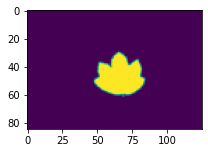

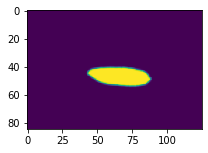

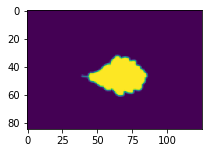

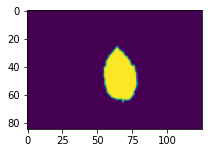

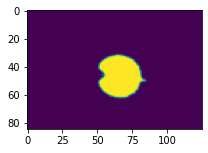

In [0]:
print("Printing original first 5 images from svd based implementation..")
model.plot_res(original1)

Printing reconstructed first 5 images from svd based implementation..


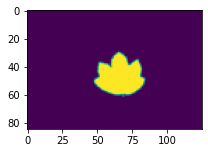

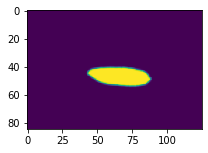

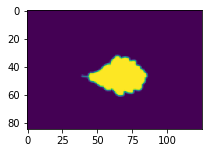

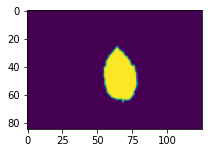

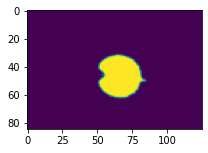

In [0]:
print("Printing reconstructed first 5 images from svd based implementation..")
model.plot_res(reconst1)

# 2.3 Plot the following to a grid of size 3 x 5
for covariance based implementation

**From Question 2.2**

Printing original first 5 images from cov based implementation..


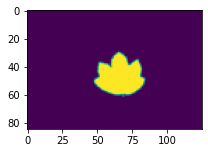

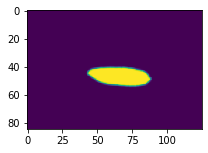

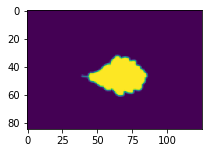

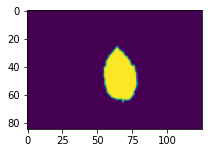

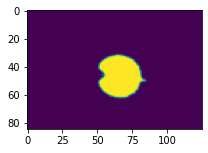

In [0]:
print("Printing original first 5 images from cov based implementation..")
model.plot_res(original2)

Printing reconstructed first 5 images from cov based implementation..


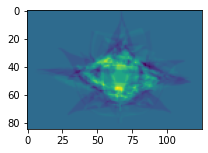

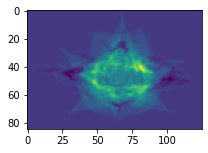

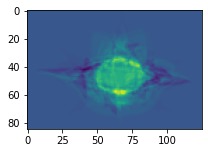

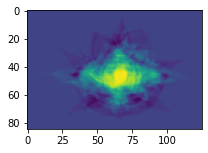

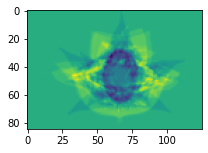

In [0]:
print("Printing reconstructed first 5 images from cov based implementation..")
model.plot_res(reconst2)